# Hybrid Model incorporating LSTM, BiLSTM and Transformer Models with for Text Summarization with the BBC Summary Dataset

#### This code implements a hybrid transformer model for text summarization, combining LSTM and transformer layers in the encoder with a transformer-based decoder. The implementation includes data preprocessing, model architecture definition, and training loop setup. The model is trained on BBC News articles, using an ensemble approach to potentially improve performance and robustness in the summarization task.

#### Advantages:

#### 1. The hybrid transformer model for text summarization leverages ensemble learning to combine multiple model instances, potentially improving accuracy and robustness by reducing individual biases and errors. 

#### 2. Additionally, its hybrid architecture, which integrates LSTM and transformer layers in the encoder, enables comprehensive feature extraction by capturing both sequential patterns and broader contextual information.

## Install dependencies

In [1]:
!pip3 install torch torchvision
!pip install rouge-score bert-score nltk

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.7 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=73c41305208eec26cbb2de28359bb6c620bdcc7ba26f178151af977159db5040
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


## Import Libraries

In [2]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from spacy.tokenizer import Tokenizer
from sklearn.model_selection import train_test_split
import spacy
import pandas as pd
import numpy as np
import os
import re
from nltk.corpus import stopwords 
import random
from tqdm import tqdm
import math
from typing import Any
import matplotlib.pyplot as plt
from tqdm import tqdm
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
import nltk

# Download necessary NLTK data
nltk.download('punkt')


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Instantiate the tokenizer using Spacy

In [3]:
# Tokenizer using spacy
nlp = spacy.load("en_core_web_sm")
tokenizer = Tokenizer(nlp.vocab)

## Define a custom function to create a dataframe from the text files

In [4]:
# Add data from files into dataframe for easier access
def create_dataframe(source_text_path,target_text_path):
    txt_files_source = [file for file in os.listdir(source_text_path) if file.endswith('.txt')]
    txt_files_target = [file for file in os.listdir(target_text_path) if file.endswith('.txt')]
    df = pd.DataFrame(columns=['headlines','text'])
    for source,target in zip(txt_files_source,txt_files_target):
        assert source==target
        source_file_path = os.path.join(source_text_path, source)
        target_file_path = os.path.join(target_text_path, target)
        # Read the content of the file
        with open(source_file_path,'r',encoding='latin-1') as file:
            source_text = file.read()
        with open(target_file_path,'r',encoding='latin-1') as file:
            target_text = file.read()
        df.loc[len(df.index)] = [source_text,target_text]
    return df

## Define functions to save the weights, load them and check for accuracy

In [5]:
# Check accuracy function
def check_accuracy(output,labels):
    _ , predpos = output.max(1)
    num_samples=len(labels)
    num_correct=(predpos==labels).sum()
    return (num_correct/num_samples)*100

# Save checkpoint
def save_checkpoint(state,filename='weights.pth.tar'):
    print('Saving weights-->')
    torch.save(state,filename)

# Load checkpoint
def load_checkpoint(checkpoint,model,optim):
    print('Loading weights-->')
    model.load_state_dict(checkpoint['state_dict'])
    optim.load_state_dict(checkpoint['optimizer'])

## Create dataframes for all the folders with Text Paragraphs and Summaries in our dataset

In [6]:
df1 = create_dataframe("/kaggle/input/bbc-news-summary/BBC News Summary/News Articles/business","/kaggle/input/bbc-news-summary/BBC News Summary/Summaries/business")
df2 = create_dataframe("/kaggle/input/bbc-news-summary/BBC News Summary/News Articles/entertainment","/kaggle/input/bbc-news-summary/BBC News Summary/Summaries/entertainment")
df3 = create_dataframe("/kaggle/input/bbc-news-summary/BBC News Summary/News Articles/politics","/kaggle/input/bbc-news-summary/BBC News Summary/Summaries/politics")
df4 = create_dataframe("/kaggle/input/bbc-news-summary/BBC News Summary/News Articles/sport","/kaggle/input/bbc-news-summary/BBC News Summary/Summaries/sport")
df5 = create_dataframe("/kaggle/input/bbc-news-summary/BBC News Summary/News Articles/tech","/kaggle/input/bbc-news-summary/BBC News Summary/Summaries/tech")

## Combine all the dataframes into one dataframe

In [7]:
df = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)

## Split the data into train and test set

In [8]:
# Split into train and test sets
df = df.rename(columns = {"headlines":"source_text","text":"summary_text"})
X,Y = df["source_text"],df["summary_text"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
train_df = pd.DataFrame({'source_text': X_train, 'summary_text': Y_train})
test_df = pd.DataFrame({'source_text': X_test, 'summary_text': Y_test})

## Add contraction mapping

In [9]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}


stop_words = set(stopwords.words('english'))

## Clean the text for punctuations and remove stop words

In [10]:
def text_cleaner(text):
    newString = text.lower()
    newString = newString.replace('"', "'")
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    return " ".join(tokens)

## Tokenize and lower case using lower case the tokens for training and test set

In [11]:
# Tokenize and lowercase text using spacy
train_df['source_text'] = train_df['source_text'].apply(lambda x: [token.text.lower() for token in tokenizer(text_cleaner(x))])
train_df['summary_text'] = train_df['summary_text'].apply(lambda x: [token.text.lower() for token in tokenizer(text_cleaner(x))])

test_df['source_text'] = test_df['source_text'].apply(lambda x: [token.text.lower() for token in tokenizer(text_cleaner(x))])
test_df['summary_text'] = test_df['summary_text'].apply(lambda x: [token.text.lower() for token in tokenizer(text_cleaner(x))])

## Add _START_ and _END_ tokens to the Summary

In [12]:
# Add START AND END tokens to summary
train_df['source_text'] = train_df['source_text'].apply(lambda x : ['_START_']+ x + ['_END_'])
train_df['summary_text'] = train_df['summary_text'].apply(lambda x : ['_START_']+ x + ['_END_'])

test_df['source_text'] = test_df['source_text'].apply(lambda x : ['_START_']+ x + ['_END_'])
test_df['summary_text'] = test_df['summary_text'].apply(lambda x : ['_START_']+ x + ['_END_'])

In [13]:
train_df.head()


,source_text,summary_text
1490,"[_START_, ferguson, fears, milan, cutting, edg...","[_START_, loss, could, worse, quality, bring, ..."
2001,"[_START_, ask, jeeves, joins, web, log, market...","[_START_, jim, lanzone, vice, president, searc..."
1572,"[_START_, safin, cool, wimbledon, newly, crown...","[_START_, expect, sampras, favourite, pressure..."
1840,"[_START_, mobiles, rack, years, use, mobile, p...","[_START_, cellnet, vodafone, mobile, phone, op..."
610,"[_START_, eminem, secret, gig, venue, revealed...","[_START_, fourth, album, rap, star, sale, two,..."


## Build vocabularies - each word has an index, note : words sorted in ascending order

In [14]:
# Build vocabularies - each word has an index, note : words sorted in ascending order
all_tokens = train_df['source_text'].tolist() + train_df['summary_text'].tolist() + test_df['source_text'].tolist() + test_df['summary_text'].tolist()
source_vocab = {actual_word: idx for idx, (word_num, actual_word) in enumerate(sorted(enumerate(set(token for tokens in all_tokens for token in tokens)), key=lambda x: x[1]))}
target_vocab = {actual_word: idx for idx, (word_num, actual_word) in enumerate(sorted(enumerate(set(token for tokens in all_tokens for token in tokens)), key=lambda x: x[1]))}

In [15]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using",device)

Using cuda


In [16]:
temp = list(sorted(source_vocab.items()))
for word, idx in temp[-5:]:
    print(word,idx)

zuluaga 27632
zurich 27633
zutons 27634
zvonareva 27635
zvyagintsev 27636


## Converting words to their corresponding vocabulary indices

In [17]:
# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, source_texts, target_summaries, source_vocab, target_vocab):
        self.source_texts = source_texts
        self.target_summaries = target_summaries
        self.source_vocab = source_vocab
        self.target_vocab = target_vocab

    def __len__(self):
        return len(self.source_texts)

    def __getitem__(self, idx):
        source_text = [self.source_vocab[word] for word in self.source_texts[idx]]
        target_summary = [self.target_vocab[word] for word in self.target_summaries[idx]]
        return torch.tensor(source_text), torch.tensor(target_summary)

## Create custom datasets

In [18]:
# Create custom datasets
train_dataset = CustomDataset(train_df['source_text'].tolist(), train_df['summary_text'].tolist(),source_vocab, target_vocab)
test_dataset = CustomDataset(test_df['source_text'].tolist(), test_df['summary_text'].tolist(),source_vocab, target_vocab)

## Find maximum sequence length

In [19]:
def get_max_seqlen():
    max_length = 0
    for index, row in train_df.iterrows():
        # Calculate the length of the current row
        row_length = len(row['source_text'])
        # Update the maximum length if the current row length is greater
        max_length = max(max_length, row_length)
    for index, row in test_df.iterrows():
        # Calculate the length of the current row
        row_length = len(row['source_text'])
        # Update the maximum length if the current row length is greater
        max_length = max(max_length, row_length)
    print("Max length in dataset ",max_length)
    return max_length

## Define collate function for DataLoader

In [20]:
# Define collate function for DataLoader
def collate_fn(batch):
    sources, targets = zip(*batch)
    padded_sources = pad_sequence(sources, batch_first=True)
    padded_targets = pad_sequence(targets, batch_first=True)
    return padded_sources, padded_targets

## This MultiHeadAttention allows the model to jointly attend to information from different representation subspaces at different positions

In [21]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embedding_dim, num_heads):
        super(MultiHeadAttention,self).__init__()
        assert embedding_dim % num_heads == 0, "embedding_dim must be divisible by num_heads"

        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.dim_perhead = embedding_dim // num_heads

        self.W_q = nn.Linear(embedding_dim, embedding_dim)
        self.W_k = nn.Linear(embedding_dim, embedding_dim)
        self.W_v = nn.Linear(embedding_dim, embedding_dim)
        self.W_o = nn.Linear(embedding_dim, embedding_dim)

    def scaled_dot_product_attention(self,Q,K,V,mask=None):
        # Q,K,V Shape : [Batch_Size X Num_Heads X Seq_len X Dim Per Head]
        
        K = K.transpose(-2,-1) # K = K.permute(0,1,3,2) also works
        # K Shape(after permute) : [Batch_Size X Num_Heads X Dim Per Head X Seq_len]
        attn_scores = torch.matmul(Q,K) / math.sqrt(self.dim_perhead)
        # attn_scores Shape : [Batch_Size X Num_Heads X Seq_len X Seq_len]
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        # attn_probs Shape : [Batch_Size X Num_Heads X Seq_len X Seq_len]
        output = torch.matmul(attn_probs, V)
        # output Shape : [Batch_Size X Num_Heads X Seq_len X Dim Per Head]
        return output

    def split_heads(self, x):
        # X shape : [Batch_Size X Seq_len X Embedding Dim]
        batch_size, seq_length, d_model = x.size()
        x = x.view(batch_size, seq_length,self.num_heads,self.dim_perhead)
        # X shape : [Batch_Size X Seq_len X Num_Heads X Dim Per Head]
        x = x.transpose(1,2)
        # X shape : [Batch_Size X Num_Heads X Seq_len X Dim Per Head]
        return x

    def combine_heads(self, x):
        # x Shape : [Batch_Size X Num_Heads X Seq_len X Dim Per Head]
        batch_size, _, seq_length, dim_perhead = x.size()
        x = x.transpose(1,2).contiguous()
        # x Shape : [Batch_Size X Seq_len X Num_Heads X Dim Per Head]
        x = x.view(batch_size, seq_length,self.embedding_dim)
        # x Shape : [Batch_Size X Seq_len X Embedding Dim]
        return x

    def forward(self, Q, K, V, mask=None):
        # Q,K,V Shape : [Batch_Size X Seq_len X Embedding Dim]
        Q = self.split_heads(self.W_q(Q)) 
        K = self.split_heads(self.W_k(K)) 
        V = self.split_heads(self.W_v(V)) 
        # Q,K,V Shape : [Batch_Size X Num_Heads X Seq_len X Dim Per Head]
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        # attn_output Shape : [Batch_Size X Num_Heads X Seq_len X Dim Per Head]
        output = self.W_o(self.combine_heads(attn_output))
        # output Shape :  # x Shape : [Batch_Size X Seq_len X Embedding Dim]
        return output

## The PositionWiseFeedForward - two linear transformations with a ReLU activation in between.

In [22]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        # shape does not change here
        return self.fc2(F.relu(self.fc1(x)))

## PositionalEncoding class adds positional information to input embeddings using sine and cosine functions of different frequencies.

In [23]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length,dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model,2).float() * -(math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe',pe.unsqueeze(0))

    def forward(self, x):
        # shape does not change here, adding positional encoding information
        return x + self.pe[:, :x.size(1)]

## The EncoderLayer class implements a single layer of the transformer encoder,

In [24]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

## The HybridEncoder class implements a hybrid encoder that combines LSTM and transformer layers to produce the final encoded output.

In [25]:
class HybridEncoder(nn.Module):
    def __init__(self, src_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(HybridEncoder, self).__init__()
        # Embedding layer to convert input tokens to dense vectors
        self.embedding = nn.Embedding(src_vocab_size, d_model)
        # Positional encoding to add position information to embeddings
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)
        # Stacked LSTM and BiLSTM layers for sequential processing
        self.lstm_layers = nn.ModuleList([
            nn.LSTM(d_model, d_model // 2, bidirectional=True, batch_first=True),
            nn.LSTM(d_model, d_model // 2, bidirectional=True, batch_first=True)
        ])
        # Transformer layers for parallel processing and attention mechanisms
        self.transformer_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask):
        # Apply embedding, positional encoding, and dropout
        embedded = self.dropout(self.positional_encoding(self.embedding(src)))
        # Process through LSTM layers
        lstm_output = embedded
        for lstm_layer in self.lstm_layers:
            lstm_output, _ = lstm_layer(lstm_output)
        # Process through transformer layers
        enc_output = lstm_output
        for layer in self.transformer_layers:
            enc_output = layer(enc_output, src_mask)
        return enc_output

## The HybridDecoderLayer class implements a single layer of the transformer decoder.

In [26]:
class HybridDecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(HybridDecoderLayer, self).__init__()
        # Self-attention mechanism
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        # Cross-attention mechanism for attending to encoder output
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        # Position-wise feed-forward network
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        # Layer normalization layers
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        # Self-attention
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        # Cross-attention with encoder output
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        # Position-wise feed-forward network
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

## The HybridTransformer class implements a hybrid transformer model combining a custom encoder with a transformer-based decoder

In [27]:
class HybridTransformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(HybridTransformer, self).__init__()
        # Custom hybrid encoder combining LSTM and transformer layers
        self.encoder = HybridEncoder(src_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)
        # Embedding layer for target sequences
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        # Positional encoding to add position information to embeddings
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)
        # Stack of decoder layers
        self.decoder_layers = nn.ModuleList([HybridDecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        # Final linear layer to project to vocabulary size
        self.fc = nn.Linear(d_model, tgt_vocab_size)
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        # Create source mask to ignore padding tokens
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        # Create target mask to ignore padding tokens
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        # Create no-peek mask for autoregressive property
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length, device=device), diagonal=1)).bool()
        # Combine padding mask and no-peek mask
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        # Generate masks for source and target sequences
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        # Encode source sequence
        enc_output = self.encoder(src, src_mask)
        # Embed target sequence and add positional encoding
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))
        
        # Pass through decoder layers
        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)
        
        # Project to vocabulary size
        output = self.fc(dec_output)
        return output

## The EnsembleModel class creates and manages multiple instances of a base model

In [28]:
class EnsembleModel(nn.Module):
    def __init__(self, num_models: int, base_model: type, *args: Any, **kwargs: Any) -> None:
        super(EnsembleModel, self).__init__()
        self.models = nn.ModuleList([base_model(*args, **kwargs) for _ in range(num_models)])

    def forward(self, src: torch.Tensor, tgt: torch.Tensor) -> torch.Tensor:
        outputs = [model(src, tgt) for model in self.models]
        return torch.mean(torch.stack(outputs), dim=0)  # Logit averaging

## Define Model Parameters

In [29]:
src_vocab_size = len(source_vocab)
tgt_vocab_size = len(target_vocab)
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 1024
max_seq_length = get_max_seqlen()
dropout = 0.1
num_workers = 2
num_epochs = 10

# Correct usage with the updated EnsembleModel class
model = EnsembleModel(3, HybridTransformer, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)

Max length in dataset  1986


## Check for trainable parameters

In [30]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(trainable_params)

231525855


## Specify optimizer and loss function

In [31]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)

## Create dataloaders


In [32]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn, num_workers=num_workers)

## Data Batch Extraction Example

In [33]:
source_dummy,target_dummy = next(iter(train_loader))

In [34]:
print(source_dummy.shape,target_dummy.shape)

torch.Size([1, 149]) torch.Size([1, 70])


In [35]:
print(source_dummy[0])


tensor([    1, 14108,  7566,  2866, 15654,  6749, 14108,  7566,  4586, 20911,
        15654, 14948,  5675,  6671, 25122,  9505,  6745,   483, 20095, 16592,
        10121, 15654, 14086,  7566, 27314,  5862, 19830,  9172, 14596, 10193,
        11736, 10763, 22405,  8397,  4031, 24990, 27115, 23023, 25914,  9172,
        15654, 18481,   596,  4587, 22405,  9634, 16456, 24992,  8397,  5862,
         7566, 24509,  3294,  1302, 13170,  5804, 13170, 16530, 12725,  4970,
        25122,  9505, 27314, 23682,  9616, 24509,  4640, 12315, 12042, 18483,
        18733, 22606, 18475, 17795, 18398,  5804,  9111, 17300, 24509, 27040,
        18483, 21118,  6277,  8039, 18475,  5663,  1530,  9505, 15654, 19940,
        25766, 11203, 24081,  7566,  9505,  8989, 23203,  9688, 11775, 21344,
        17171,  2367,  4588, 11471, 16801,  4586,   759,  8125, 23139,  1962,
        25062, 23052, 24990,  8961,  4711,  2093, 14208, 15654, 16388,  4586,
         3958, 27314,  9505, 10511,  2720,  9124,   759,  9293, 

In [36]:
print(torch.min(target_dummy),torch.max(target_dummy))


tensor(0) tensor(27314)


In [37]:
model.to(device)
source_dummy = source_dummy.to(device)
target_dummy = target_dummy.to(device)
print()

In [38]:
# Call the prediction and check its prediction
y_pred = model(source_dummy,target_dummy)
print(y_pred.shape,target_dummy.shape)

torch.Size([1, 70, 27637]) torch.Size([1, 70])


In [39]:
# Call the prediction and check its prediction
y_pred = y_pred.reshape(-1,len(target_vocab))
target_dummy = target_dummy.reshape(-1)
print(y_pred.shape,target_dummy.shape)

torch.Size([70, 27637]) torch.Size([70])


## Plot the Training loss and the Accuracy against the Epochs

In [40]:
def plot_training_metrics(losses, accuracies):
    # Create a range of epochs for the x-axis
    epochs = range(1, len(losses) + 1)

    # Set up the figure and axes
    plt.figure(figsize=(10, 6))
    fig, ax1 = plt.subplots()

    # Plot loss on the primary y-axis
    color = 'tab:red'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(epochs, losses, color=color, label='Training Loss')
    ax1.tick_params(axis='y', labelcolor=color)

    # Create a secondary y-axis for accuracy
    ax2 = ax1.twinx()

    # Plot accuracy on the secondary y-axis
    color = 'tab:blue'
    ax2.set_ylabel('Accuracy', color=color)
    ax2.plot(epochs, accuracies, color=color, label='Training Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)

    # Set the title and adjust layout
    plt.title('Training Metrics')
    fig.tight_layout()
    
    # Combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

    # Display the plot
    plt.show()

## Define the training loop

In [41]:
def train_loop(model, dataloader, loss_fun, optimizer, device, scheduler=None, num_epochs=40):
    model.train()  # Set model to training mode
    model.to(device)  # Move model to specified device (CPU/GPU)
    min_loss = float('inf')  # Initialize minimum loss for model checkpointing
    
    # Lists to store per-epoch metrics
    epoch_losses = []
    epoch_accuracies = []

    for epoch in range(num_epochs):
        losses = []
        accuracies = []
        loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=True)  # Progress bar for each epoch
        for batch, (x, y) in loop:
            x = x.to(device)  # Move input to device
            y = y.to(device)  # Move target to device
            y_pred = model(x, y)  # Forward pass

            # Reshape predictions and targets for loss calculation
            batch_size, seq_len, vocab_size = y_pred.shape
            y_pred = y_pred.reshape(-1, vocab_size)
            y = y.reshape(-1)

            # Calculate loss and accuracy
            loss = loss_fun(y_pred, y)
            losses.append(loss.item())
            accuracy = check_accuracy(y_pred, y)
            accuracies.append(accuracy.item())

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()

            if scheduler:
                scheduler.step()  # Update learning rate

            # Update progress bar
            loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
            loop.set_postfix(loss=loss.item(), accuracy=accuracy.item())

        # Calculate average loss and accuracy for the epoch
        moving_loss = sum(losses) / len(losses)
        moving_accuracy = sum(accuracies) / len(accuracies)
        
        # Store epoch metrics for plotting
        epoch_losses.append(moving_loss)
        epoch_accuracies.append(moving_accuracy)

        # Save checkpoint if loss improves
        checkpoint = {
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }
        if moving_loss < min_loss:
            min_loss = moving_loss
            save_checkpoint(checkpoint)

        print(f'Epoch {epoch+1}: Loss = {moving_loss:.4f}, Training Accuracy = {moving_accuracy:.4f}')

    # Plot training metrics after all epochs
    plot_training_metrics(epoch_losses, epoch_accuracies)
    return model

## Train the Model

Epoch [1/10]: 100%|██████████| 1780/1780 [06:15<00:00,  4.73it/s, accuracy=83.9, loss=3.43]


Saving weights-->
Epoch 1: Loss = 5.7625, Training Accuracy = 48.8213


Epoch [2/10]: 100%|██████████| 1780/1780 [06:15<00:00,  4.74it/s, accuracy=67.1, loss=3.77] 


Saving weights-->
Epoch 2: Loss = 2.7935, Training Accuracy = 79.5895


Epoch [3/10]: 100%|██████████| 1780/1780 [06:15<00:00,  4.74it/s, accuracy=93, loss=0.762]  


Saving weights-->
Epoch 3: Loss = 1.9098, Training Accuracy = 87.2194


Epoch [4/10]: 100%|██████████| 1780/1780 [06:15<00:00,  4.74it/s, accuracy=90.1, loss=1.28]  


Saving weights-->
Epoch 4: Loss = 1.4418, Training Accuracy = 90.6151


Epoch [5/10]: 100%|██████████| 1780/1780 [06:16<00:00,  4.73it/s, accuracy=87.5, loss=0.834] 


Saving weights-->
Epoch 5: Loss = 1.1419, Training Accuracy = 92.6623


Epoch [6/10]: 100%|██████████| 1780/1780 [06:16<00:00,  4.73it/s, accuracy=93.9, loss=0.736]  


Saving weights-->
Epoch 6: Loss = 0.9369, Training Accuracy = 94.1359


Epoch [7/10]: 100%|██████████| 1780/1780 [06:16<00:00,  4.73it/s, accuracy=98.7, loss=0.411]  


Saving weights-->
Epoch 7: Loss = 0.7861, Training Accuracy = 95.3073


Epoch [8/10]: 100%|██████████| 1780/1780 [06:14<00:00,  4.75it/s, accuracy=96.6, loss=0.526]  


Saving weights-->
Epoch 8: Loss = 0.6707, Training Accuracy = 96.2365


Epoch [9/10]: 100%|██████████| 1780/1780 [06:11<00:00,  4.79it/s, accuracy=97.2, loss=0.467]  


Saving weights-->
Epoch 9: Loss = 0.5775, Training Accuracy = 97.0970


Epoch [10/10]: 100%|██████████| 1780/1780 [06:12<00:00,  4.78it/s, accuracy=90.8, loss=1.03]    


Saving weights-->
Epoch 10: Loss = 0.5000, Training Accuracy = 97.7826


<Figure size 1000x600 with 0 Axes>

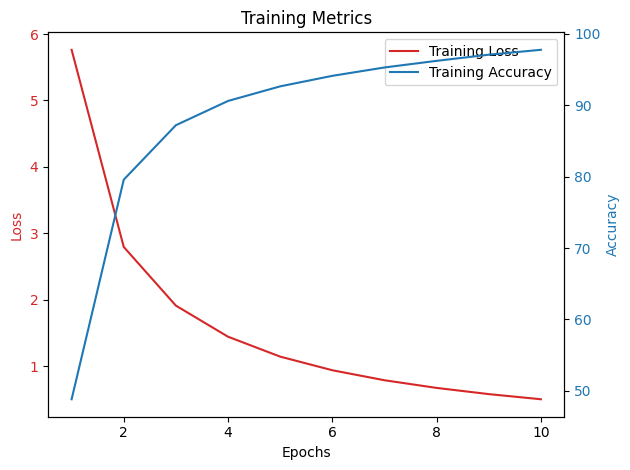

In [42]:
model = train_loop(model, train_loader, criterion, optimizer, device, scheduler, num_epochs=num_epochs)

## Assess the performance of a trained model on a given dataset

In [43]:
def evaluate(model, dataloader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    
    with torch.no_grad():  # Disable gradient calculation for efficiency
        for batch in dataloader:
            src, tgt = batch
            src, tgt = src.to(device), tgt.to(device)  # Move data to the specified device
            
            # Generate predictions, excluding the last token of the target
            output = model(src, tgt[:, :-1])
            
            # Calculate loss, comparing predictions to target (shifted by one position)
            loss = criterion(output.contiguous().view(-1, output.size(-1)), 
                             tgt[:, 1:].contiguous().view(-1))
            
            total_loss += loss.item()  # Accumulate the loss
    
    # Return the average loss across all batches
    return total_loss / len(dataloader)

## Assess the performance of a trained model on a test dataset using ROUGE and BLEU metrics.

In [44]:
def evaluate_model(model, test_loader, target_vocab, device):
    model.eval()  # Set the model to evaluation mode
    hypotheses = []
    references = []
    
    # Create a reverse vocabulary for index to word mapping
    reverse_target_vocab = {v: k for k, v in target_vocab.items()}
    
    # Initialize the ROUGE scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    
    with torch.no_grad():  # Disable gradient calculation for efficiency
        for source, target in test_loader:
            source = source.to(device)
            target = target.to(device)
            
            # Generate summary
            output = model(source, target)
            _, predicted = output.max(dim=2)
            
            for i in range(len(source)):
                # Convert predicted and target sequences to words
                pred_words = [reverse_target_vocab[idx.item()] for idx in predicted[i] if idx.item() in reverse_target_vocab]
                target_words = [reverse_target_vocab[idx.item()] for idx in target[i] if idx.item() in reverse_target_vocab]
                
                hypotheses.append(' '.join(pred_words))
                references.append(' '.join(target_words))
    
    # Calculate ROUGE scores
    rouge_scores = {key: {'f': 0, 'p': 0, 'r': 0} for key in ['rouge1', 'rouge2', 'rougeL']}
    for hyp, ref in zip(hypotheses, references):
        scores = scorer.score(ref, hyp)
        for key in scores:
            rouge_scores[key]['f'] += scores[key].fmeasure
            rouge_scores[key]['p'] += scores[key].precision
            rouge_scores[key]['r'] += scores[key].recall
    
    # Average ROUGE scores
    n = len(hypotheses)
    for key in rouge_scores:
        for metric in rouge_scores[key]:
            rouge_scores[key][metric] /= n
    
    # Calculate BLEU score
    bleu_score = corpus_bleu([[r.split()] for r in references], [h.split() for h in hypotheses])
    
    return rouge_scores, bleu_score

## Evaluates the trained model on the test dataset, calculating loss, ROUGE scores, and BLEU score.

In [45]:
def test_loop(model, test_loader, loss_fun, device):
    model.eval()  # Set the model to evaluation mode
    model.to(device)  # Move the model to the specified device
    total_loss = 0
    
    # Evaluate the model using ROUGE and BLEU metrics
    rouge_scores, bleu_score = evaluate_model(model, test_loader, target_vocab, device)
    
    with torch.no_grad():  # Disable gradient calculation for efficiency
        for batch, (x, y) in enumerate(test_loader):
            x = x.to(device)
            y = y.to(device)
            output = model(x, y)  # Generate predictions
            
            # Calculate loss
            loss = loss_fun(output.view(-1, output.size(-1)), y.view(-1))
            total_loss += loss.item()
    
    # Calculate average loss
    avg_loss = total_loss / len(test_loader)
    
    # Print evaluation results
    print(f"Test Loss: {avg_loss:.4f}")
    print("ROUGE Scores:")
    for key, values in rouge_scores.items():
        print(f"  {key}: F1 = {values['f']:.4f}, Precision = {values['p']:.4f}, Recall = {values['r']:.4f}")
    print(f"BLEU Score: {bleu_score:.4f}")
    
    return avg_loss, rouge_scores, bleu_score

## Call the function

In [46]:
# Call the test loop after training
test_loss, rouge_scores, bleu_score = test_loop(model, test_loader, criterion, device)

Test Loss: 0.9144
ROUGE Scores:
  rouge1: F1 = 0.9306, Precision = 0.9306, Recall = 0.9306
  rouge2: F1 = 0.8807, Precision = 0.8807, Recall = 0.8807
  rougeL: F1 = 0.9304, Precision = 0.9304, Recall = 0.9304
BLEU Score: 0.8632
